# Dependencies and data load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from scipy.stats import wasserstein_distance, pearsonr, spearmanr

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler, Adam
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel

from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

import gc
from tqdm import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def acc(x, y):
  return (torch.argmax(x) == torch.argmax(y)).double()

In [ ]:
transformer_path = 'bert-large-cased'

In [ ]:
batch_size = 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/emotion detection/train/train_df.csv', index_col='index')
test_df = pd.read_csv('/content/drive/MyDrive/emotion detection/test/test_df.csv', index_col='index')

In [ ]:
df = pd.concat((train_df, test_df))

In [ ]:
df.columns = ['text', 'Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise']
df = df.drop('Disgust', axis=1)

In [ ]:
features = list(df.columns[-5:])
features

['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']

In [ ]:
df[features] = df[features].apply(lambda it: it/it.sum() if it.sum() else 0, axis=1)
df.head()

,text,Anger,Fear,Joy,Sadness,Surprise
index,,,,,,
1,Mortar assault leaves at least 18 dead,0.150685,0.410959,0.000000,0.438356,0.000000
2,Goal delight for Sheva,0.000000,0.000000,0.709924,0.000000,0.290076
3,Nigeria hostage feared dead is freed,0.081448,0.235294,0.298643,0.090498,0.294118
4,Bombers kill shoppers,0.268293,0.382114,0.000000,0.349593,0.000000
5,"Vegetables, not fruit, slow brain decline",0.000000,0.252525,0.262626,0.020202,0.464646


In [ ]:
tmp, valid_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, test_df = train_test_split(tmp, test_size=2/8, random_state=42)

# Dataset class

In [ ]:
tokenizer = BertTokenizer.from_pretrained(transformer_path)

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = df[features].reset_index()
        self.texts = df[["text"]].reset_index()

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels.loc[idx].values[1:]).astype(float)

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        text = self.texts.loc[idx].values[1]
        text = (tokenizer.sep_token).join(sent_tokenize(text))
        return tokenizer(text, 
                        padding='max_length', max_length = 512, truncation=True,
                        return_tensors="pt")

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

# Model

In [ ]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class MaxPooling(nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim = 1)
        return max_embeddings
    
class MinPooling(nn.Module):
    def __init__(self):
        super(MinPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = 1e-4
        min_embeddings, _ = torch.min(embeddings, dim = 1)
        return min_embeddings
    
class TransformerModel(nn.Module):

    def __init__(self):

        super(TransformerModel, self).__init__()

        self.bert = BertModel.from_pretrained(transformer_path)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.3)
        self.dropout4 = nn.Dropout(0.4)
        self.dropout5 = nn.Dropout(0.5)
        self.clf = nn.Sequential(
            nn.Linear(1024, len(features)),
            nn.Softmax(dim=1)
        )
        # self.pool = MeanPooling()

    def forward(self, input_id, mask):

        _, x = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        # x = self.pool(x, mask)
        
        # layer_weight = F.softmax(self.hidden_layer_weights, dim = 1)
        # out_mean = torch.sum(hidden_states * layer_weight, dim = 1)
        # x = self.layer_norm(out_mean)
        
        x1 = self.dropout1(x)
        x2 = self.dropout2(x)
        x3 = self.dropout3(x)
        x4 = self.dropout4(x)
        x5 = self.dropout5(x)
        x = (x1 + x2 + x3 + x4 + x5) / 5
        out = self.clf(x)
        return out

# Train

In [ ]:
def train(model, train_data, val_data, epochs):

  train, val = Dataset(train_data), Dataset(val_data)
  if torch.cuda.is_available():  
      dev = "cuda:0" 
  else:  
      dev = "cpu"  
  device = torch.device(dev) 
  criterion = nn.MSELoss()
  optimizer = Adam(model.parameters(), lr=1e-5)
  scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=500, 
                                                                eta_min=1e-6)

  train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
  val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  if use_cuda:

          model = model.cuda()
          criterion = criterion.cuda()

  for epoch_num in range(epochs):

        total_loss_train = 0

        for train_input, train_labels in tqdm(train_dataloader):

            train_labels = train_labels.to(device).float()
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_labels)
            total_loss_train += batch_loss.item()
            
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
            scheduler.step()
        
        total_loss_val = 0
        pred = []
        labels = []
        with torch.no_grad():
            
            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                pred += [output]
                labels += [val_label]

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

        
        torch.save(model.state_dict(), f'bert_{epoch_num+1}.pt') 
        pred = torch.cat(pred, dim=0).cpu()
        labels = torch.cat(labels, dim=0).cpu()

        acc_1 = torch.mean(torch.tensor([acc(pred[i], labels[i]) for i in range(pred.size()[0])]))
        APd = torch.mean(torch.tensor([pearsonr(pred[i], labels[i])[0] for i in range(pred.size()[0])]))
        ASd = torch.mean(torch.tensor([spearmanr(pred[i], labels[i])[0] for i in range(pred.size()[0])]))
        APe = torch.mean(torch.tensor([pearsonr(pred[:, i], labels[:, i])[0] for i in range(len(features))]))
        ASe = torch.mean(torch.tensor([spearmanr(pred[:, i], labels[:, i])[0] for i in range(len(features))]))
        RMSED = torch.mean(torch.tensor([np.sqrt(nn.functional.mse_loss(pred[i:i+1, :], labels[i:i+1, :])) for i in range(pred.size()[0])]))
        WD = torch.mean(torch.tensor([wasserstein_distance(pred[i], labels[i]) for i in range(pred.size()[0])]))
        print(f'EPOCH {epoch_num + 1}')
        print(f'Test Loss: {total_loss_val / len(val_data): .3f}')
        print(f'ACC@1: {acc_1:0.4f}, RMSED: {RMSED:0.4f}, WD: {WD:0.4f}')
        print(f'APd: {APd:0.4f}, ASd: {ASd:0.4f}, APe: {APe:0.4f}, ASe: {ASe:0.4f}')


In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
    criterion = nn.MSELoss()
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_loss_test = 0
    pred = []
    labels = []
    with torch.no_grad():

        for test_input, test_labels in tqdm(test_dataloader):

            test_labels = test_labels.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            pred += [output]
            labels += [test_labels]

            loss = criterion(output, test_labels)
            total_loss_test += loss
    
    pred = torch.cat(pred, dim=0).cpu()
    labels = torch.cat(labels, dim=0).cpu()

    acc_1 = torch.mean(torch.tensor([acc(pred[i], labels[i]) for i in range(pred.size()[0])]))
    APd = torch.mean(torch.tensor([pearsonr(pred[i], labels[i])[0] for i in range(pred.size()[0])]))
    ASd = torch.mean(torch.tensor([spearmanr(pred[i], labels[i])[0] for i in range(pred.size()[0])]))
    APe = torch.mean(torch.tensor([pearsonr(pred[:, i], labels[:, i])[0] for i in range(len(features))]))
    ASe = torch.mean(torch.tensor([spearmanr(pred[:, i], labels[:, i])[0] for i in range(len(features))]))
    RMSED = torch.mean(torch.tensor([np.sqrt(nn.functional.mse_loss(pred[i:i+1, :], labels[i:i+1, :])) for i in range(output.size()[0])]))
    WD = torch.mean(torch.tensor([wasserstein_distance(pred[i], labels[i]) for i in range(pred.size()[0])]))
    print(f'Test Loss: {total_loss_test / len(test_data): .3f}')
    print(f'ACC@1: {acc_1:0.4f}, RMSED: {RMSED:0.4f}, WD: {WD:0.4f}')
    print(f'APd: {APd:0.4f}, ASd: {ASd:0.4f}, APe: {APe:0.4f}, ASe: {ASe:0.4f}')

In [ ]:
EPOCHS = 10
model = TransformerModel()

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train(model, train_df, valid_df, EPOCHS)

100%|██████████| 188/188 [04:03<00:00,  1.30s/it]


Test Loss:  0.007
ACC@1: 0.5240, RMSED: 0.1541, WD: 0.0974
APd: 0.5767, ASd: 0.5448, APe: 0.5842, ASe: 0.6144


100%|██████████| 188/188 [04:01<00:00,  1.29s/it]


Test Loss:  0.006
ACC@1: 0.5680, RMSED: 0.1416, WD: 0.0860
APd: 0.6220, ASd: 0.5859, APe: 0.6351, ASe: 0.6505


100%|██████████| 188/188 [04:01<00:00,  1.29s/it]


Test Loss:  0.007
ACC@1: 0.5800, RMSED: 0.1420, WD: 0.0827
APd: 0.6270, ASd: 0.5830, APe: 0.6349, ASe: 0.6549


100%|██████████| 188/188 [04:02<00:00,  1.29s/it]


Test Loss:  0.006
ACC@1: 0.6160, RMSED: 0.1374, WD: 0.0806
APd: 0.6471, ASd: 0.6165, APe: 0.6502, ASe: 0.6711


100%|██████████| 188/188 [04:01<00:00,  1.29s/it]


Test Loss:  0.006
ACC@1: 0.6320, RMSED: 0.1328, WD: 0.0776
APd: 0.6644, ASd: 0.6147, APe: 0.6724, ASe: 0.6812


100%|██████████| 188/188 [04:01<00:00,  1.29s/it]


Test Loss:  0.006
ACC@1: 0.6040, RMSED: 0.1371, WD: 0.0795
APd: 0.6493, ASd: 0.6114, APe: 0.6549, ASe: 0.6723


100%|██████████| 188/188 [04:01<00:00,  1.28s/it]


Test Loss:  0.006
ACC@1: 0.6200, RMSED: 0.1339, WD: 0.0788
APd: 0.6687, ASd: 0.6255, APe: 0.6750, ASe: 0.6900


100%|██████████| 188/188 [04:01<00:00,  1.28s/it]


Test Loss:  0.006
ACC@1: 0.6120, RMSED: 0.1330, WD: 0.0750
APd: 0.6623, ASd: 0.6230, APe: 0.6659, ASe: 0.6849


100%|██████████| 188/188 [04:01<00:00,  1.29s/it]


Test Loss:  0.006
ACC@1: 0.6080, RMSED: 0.1340, WD: 0.0743
APd: 0.6535, ASd: 0.6182, APe: 0.6664, ASe: 0.6838


100%|██████████| 188/188 [04:01<00:00,  1.28s/it]


Test Loss:  0.006
ACC@1: 0.6240, RMSED: 0.1303, WD: 0.0757
APd: 0.6699, ASd: 0.6137, APe: 0.6797, ASe: 0.6898


In [ ]:
gc.collect()

19

In [ ]:
model.load_state_dict(torch.load('bert_5.pt'))

<All keys matched successfully>

In [ ]:
evaluate(model, test_df)

100%|██████████| 125/125 [00:30<00:00,  4.10it/s]


Test Loss:  0.010
ACC@1: 0.7120, RMSED: 0.0752, WD: 0.0735
APd: 0.7432, ASd: 0.7042, APe: 0.7320, ASe: 0.7195


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/emotion detection/best_bert_model.pt')

### My Bi-lstm (same partition)

Acc@1:  0.5060

APd:  0.5223

APe:  0.5267

RMSED:  0.1631

WDD:  0.1009

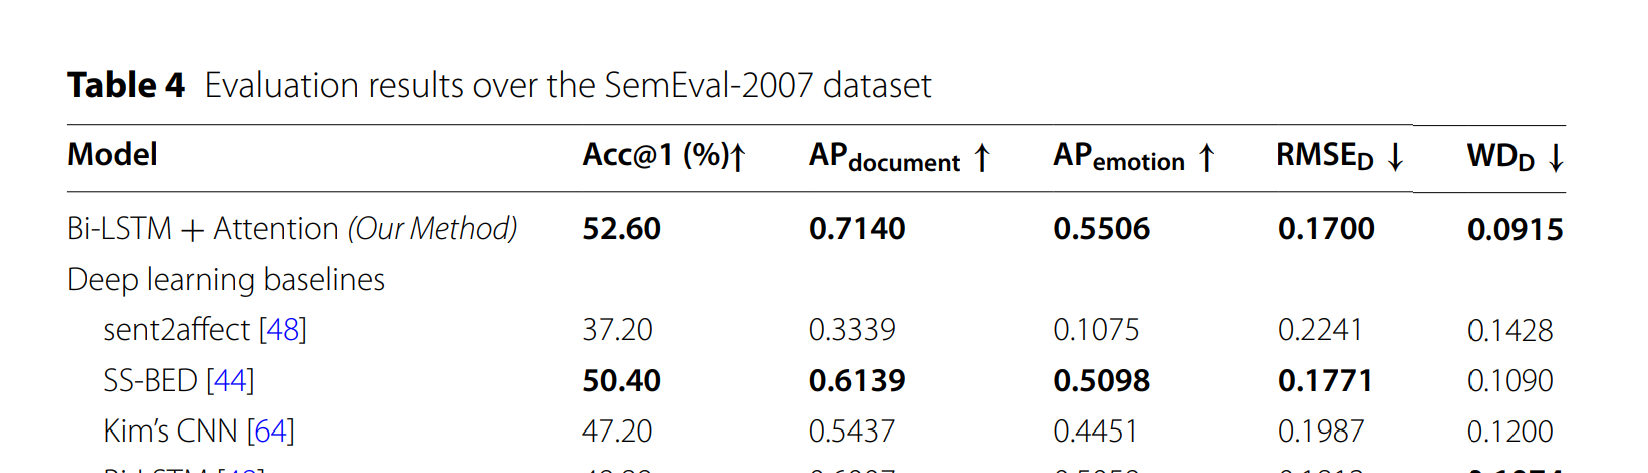